In [1]:
from pathlib import Path
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image
from Helper import *

# Import the official FlyingChairs IO loader
import IO  # your uploaded file


In [2]:
class FlyingChairsOfficial(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.root = Path(root)
        self.transform = transform

        # read train/val assignment file
        split_file = self.root / "FlyingChairs_train_val.txt"
        split_ids = np.loadtxt(split_file, dtype=np.int32)  # array of 1 or 2

        if split == "train":
            self.indices = np.where(split_ids == 1)[0] + 1
        elif split == "val":
            self.indices = np.where(split_ids == 2)[0] + 1
        else:
            self.indices = np.arange(1, len(split_ids) + 1)

        self.data_dir = self.root / "data"

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        n = int(self.indices[idx])

        img1_path = self.data_dir / f"{n:05d}_img1.ppm"
        img2_path = self.data_dir / f"{n:05d}_img2.ppm"
        flow_path = self.data_dir / f"{n:05d}_flow.flo"

        # use official IO functions
        img1 = IO.read(str(img1_path))
        img2 = IO.read(str(img2_path))
        flow = IO.read(str(flow_path))  # H × W × 2

        # convert to PIL for transforms
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # flow to tensor: HWC → CHW
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()

        return img1, img2, flow


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

root = r"C:\Users\simon\Desktop\RV\Racunalniski Vid\RV-N3\datasets\FlyingChairs_release"

transform = transforms.ToTensor()

dataset = FlyingChairsOfficial(root=root, transform=transform, split="train")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

imgs1, imgs2, flows = next(iter(loader))
print(imgs1.shape, imgs2.shape, flows.shape)


torch.Size([4, 3, 384, 512]) torch.Size([4, 3, 384, 512]) torch.Size([4, 2, 384, 512])


In [4]:
imgs1, imgs2, flows = next(iter(loader))

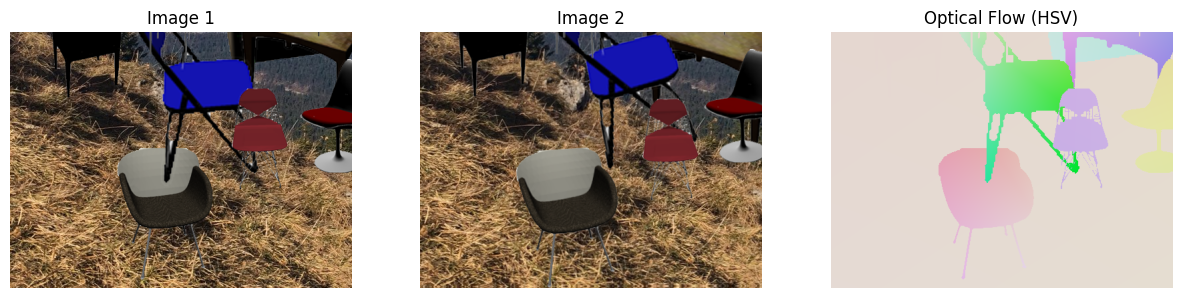

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# take example batch already loaded
img1 = imgs1[0].permute(1, 2, 0).numpy()
img2 = imgs2[0].permute(1, 2, 0).numpy()
flow = flows[0].permute(1, 2, 0).numpy()  # H×W×2 (u,v)

# split flow
u = flow[:, :, 0]
v = flow[:, :, 1]

# magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)  # [-pi, pi]

# normalize for HSV
h = (ang + np.pi) / (2 * np.pi)  # hue ∈ [0,1]
s = mag / (mag.max() + 1e-6)  # saturation ∈ [0,1]
v_ = np.ones_like(s) * 0.9  # brightness = 1 (or adjust lower)

# build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(img2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Optical Flow (HSV)")
plt.imshow(rgb_flow)
plt.axis("off")

plt.show()


In [6]:
# Cell: Training setup
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose([
    # transforms.Resize((32, 32)),  # Much smaller for CPU
    transforms.ToTensor()
])

# Create datasets
train_dataset = FlyingChairsOfficial(root=root, split="train", transform=transform)
val_dataset = FlyingChairsOfficial(root=root, split="val", transform=transform)

# Data loaders
batch_size = 8  # Use 1 for CPU training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Using device: cuda
Train samples: 22232
Val samples: 640


In [7]:
# Cell: Iteration-based Training Loop
from Model import FlowNetSimple, MultiScaleEPE
import itertools

# Initialize model
model = FlowNetSimple().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = MultiScaleEPE(weights=(1.0, 0.5, 0.25))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training configuration
max_iterations = 500000  # 500k iterations as per assignment
val_interval = 100      # Validate every 1000 iterations
save_interval = 5000    # Save checkpoint every 10k iterations
log_interval = 10       # Log progress every 100 iterations

# Learning rate scheduler: halve every 100k steps after 200k steps
def adjust_learning_rate(optimizer, iteration):
    """Adjust learning rate according to assignment specs"""
    if iteration >= 200000:
        # After 200k, halve every 100k iterations
        num_halvings = (iteration - 200000) // 100000 + 1
        lr = 1e-4 / (2 ** num_halvings)
    else:
        lr = 1e-4

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# Setup checkpoint directory
checkpoint_dir = Path('./checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Load checkpoint if exists
checkpoint = load_checkpoint_generic(checkpoint_dir, device)

# Initialize tracking variables
train_losses = []
val_losses = []
val_epes = []
iterations_log = []
start_iteration = 1

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iteration = checkpoint.get('iteration', 0) + 1

    # Load tracking variables if they exist
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_epes = checkpoint.get('val_epes', [])
    iterations_log = checkpoint.get('iterations_log', [])

    print(f"Resuming training from iteration {start_iteration}")
else:
    print("No checkpoint found, starting fresh training.")

best_val_loss = checkpoint.get('best_val_loss', float('inf')) if checkpoint else float('inf')
running_loss = 0.0

# Create infinite data loader iterator
train_iterator = itertools.cycle(train_loader)

model.train()
print(f"\nStarting training from iteration {start_iteration} to {max_iterations:,}...")

for iteration in range(start_iteration, max_iterations + 1):
    # Get batch
    img1, img2, flow_gt = next(train_iterator)
    img1 = img1.to(device)
    img2 = img2.to(device)
    flow_gt = flow_gt.to(device)

    # Concatenate images
    inputs = torch.cat([img1, img2], dim=1)

    # Forward pass
    optimizer.zero_grad()
    flow_preds = model(inputs)

    # Compute loss
    loss, epe1, epe2, epe3 = criterion(flow_preds, flow_gt)

    # Backward pass
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Adjust learning rate
    current_lr = adjust_learning_rate(optimizer, iteration)

    # Log progress
    if iteration % log_interval == 0:
        avg_loss = running_loss / log_interval
        print(f"Iter {iteration:6d}/{max_iterations:6d} | Loss: {avg_loss:.4f} | LR: {current_lr:.6f}")
        running_loss = 0.0

    # Validation
    if iteration % val_interval == 0:
        model.eval()
        val_loss = 0.0
        val_epe = 0.0

        with torch.no_grad():
            for img1_v, img2_v, flow_gt_v in val_loader:
                img1_v = img1_v.to(device)
                img2_v = img2_v.to(device)
                flow_gt_v = flow_gt_v.to(device)

                inputs_v = torch.cat([img1_v, img2_v], dim=1)
                flow_preds_v = model(inputs_v)

                loss_v, epe1_v, _, _ = criterion(flow_preds_v, flow_gt_v)
                val_loss += loss_v.item()
                val_epe += epe1_v.item()

        val_loss /= len(val_loader)
        val_epe /= len(val_loader)

        val_losses.append(val_loss)
        val_epes.append(val_epe)
        iterations_log.append(iteration)

        print(f">>> Validation at iter {iteration:6d} | Val Loss: {val_loss:.4f} | Val EPE: {val_epe:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'iteration': iteration,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_epe': val_epe,
                'lr': current_lr
            }, 'best_flownet_model.pth')
            print(f"✓ Saved best model (EPE: {val_epe:.4f})")

        model.train()

    # Save checkpoint periodically
    if iteration % save_interval == 0:
        save_checkpoint_generic(
            checkpoint_dir,
            iteration,
            {
                'iteration': iteration,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr': current_lr,
                'best_val_loss': best_val_loss,
                'val_losses': val_losses,
                'val_epes': val_epes,
                'iterations_log': iterations_log
            },
            max_checkpoints=5  # Keep last 5 checkpoints
        )

print("\n🎉 Training completed!")

Model parameters: 387,518
🚀 No checkpoint found, starting from scratch
No checkpoint found, starting fresh training.

Starting training from iteration 1 to 500,000...
Iter     10/500000 | Loss: 16.2896 | LR: 0.000100
Iter     20/500000 | Loss: 12.6162 | LR: 0.000100


KeyboardInterrupt: 

In [ ]:
# Visualization function for predicted flow
def visualize_flow_prediction(model, dataset, idx=0, device='cpu'):
    """
    Visualize model's flow prediction
    """
    model.eval()
    model = model.to(device)

    img1, img2, flow_gt = dataset[idx]

    # Add batch dimension
    img1_batch = img1.unsqueeze(0).to(device)
    img2_batch = img2.unsqueeze(0).to(device)

    # Concatenate images
    input_images = torch.cat([img1_batch, img2_batch], dim=1)

    # Predict flow
    with torch.no_grad():
        flow_pred = model(input_images)

    # Convert to numpy
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    flow_gt_np = flow_gt.permute(1, 2, 0).cpu().numpy()
    flow_pred_np = flow_pred[0].permute(1, 2, 0).cpu().numpy()

    # Visualize using HSV color coding
    def flow_to_hsv(flow):
        u = flow[:, :, 0]
        v = flow[:, :, 1]

        mag = np.sqrt(u ** 2 + v ** 2)
        ang = np.arctan2(v, u)

        h = (ang + np.pi) / (2 * np.pi)
        s = mag / (mag.max() + 1e-6)
        v_ = np.ones_like(s)

        hsv = np.stack([h, s, v_], axis=-1)
        return mcolors.hsv_to_rgb(hsv)

    flow_gt_hsv = flow_to_hsv(flow_gt_np)
    flow_pred_hsv = flow_to_hsv(flow_pred_np)

    # Compute endpoint error
    epe = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2).mean()

    # Plot
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.title("Image 1")
    plt.imshow(img1_np)
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.title("Image 2")
    plt.imshow(img2_np)
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.title("Ground Truth Flow")
    plt.imshow(flow_gt_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.title(f"Predicted Flow (EPE: {epe:.2f})")
    plt.imshow(flow_pred_hsv)
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.title("Error Map")
    error_map = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2)
    plt.imshow(error_map, cmap='hot')
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Average Endpoint Error: {epe:.4f} pixels")


In [ ]:
# Test visualization with untrained model
# visualize_flow_prediction(model, val_dataset, idx=0, device=device)


In [ ]:
# Plot training curves
def plot_training_curves(iterations_log, val_losses):
    """Plot validation losses over iterations"""
    plt.figure(figsize=(12, 5))
    plt.plot(iterations_log, val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot after training
plot_training_curves(iterations_log, val_losses)

# Plot EPE over iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations_log, val_epes, label='Validation EPE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('EPE (pixels)')
plt.title('Validation Endpoint Error over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cell: Load best model and visualize
best_model_path = checkpoint_dir / 'best_flownet_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from iteration {checkpoint['iteration']}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")

# Visualize predictions
visualize_flow_prediction(model, val_dataset, idx=0, device=device)
visualize_flow_prediction(model, val_dataset, idx=5, device=device)